# Order of magnitude faster training for image classification: Part I

### _Transfer learning using Inception Package - Local Run Experience_
This notebook codifies the capabilities discussed in this [blog post](http://localhost:8081/). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. For explanation, simple flower images are used. Compared to training from scratch, the time and costs are drastically reduced.

This notebook does all operations in the Datalab container without calling CloudML API. Hence, this is called "local" operations - though Datalab itself is most often running on a GCE VM. See the corresponding cloud notebook for cloud experience which only adds the --cloud parameter and some config to the local experience commands. The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

## Setup
All data is available under gs://cloud-datalab/sampledata/flower. eval100 is a subset of eval300, which is a subset of eval670. Same for train data.

In [43]:
!mkdir -p /content/flowerdata

In [44]:
!gsutil -m cp gs://cloud-datalab/sampledata/flower/* /content/flowerdata

Copying gs://cloud-datalab/sampledata/flower/all.csv...
Copying gs://cloud-datalab/sampledata/flower/eval100.csv...
Copying gs://cloud-datalab/sampledata/flower/eval300.csv...
Copying gs://cloud-datalab/sampledata/flower/eval670.csv...
Copying gs://cloud-datalab/sampledata/flower/train1000.csv...
Copying gs://cloud-datalab/sampledata/flower/train200.csv...
Copying gs://cloud-datalab/sampledata/flower/train300.csv...
Copying gs://cloud-datalab/sampledata/flower/train3000.csv...


Define directories for preprocessing, model, and prediction.

In [45]:
import mltoolbox.image.classification as model
from google.datalab.ml import *

worker_dir = '/content/datalab/tmp/flower'
preprocessed_dir = worker_dir + '/flowerrunlocal'
model_dir = worker_dir + '/tinyflowermodellocal'
prediction_dir = worker_dir + '/flowermodelevallocal'
images_dir = worker_dir + '/images'
local_train_file = '/content/flowerdata/train200local.csv'
local_eval_file = '/content/flowerdata/eval100local.csv'

In [46]:
!mkdir -p {images_dir}

In order to get best efficiency, we download the images to local disk, and create our training and evaluation files to reference local path instead of GCS path. Note that the original training files referencing GCS image paths work too, although a bit slower.

In [47]:
import csv
import google.datalab.storage as gcs
import os


def download_images(input_csv, output_csv, images_dir):
  with open(input_csv) as csvfile:
    data = list(csv.DictReader(csvfile, fieldnames=['image_url', 'label']))
  for x in data:
    url = x['image_url']
    out_file = os.path.join(images_dir, os.path.basename(url))
    with open(out_file, 'w') as f:
      f.write(gcs.Item.from_url(url).read_from())
    x['image_url'] = out_file

  with open(output_csv, 'w') as w:
    csv.DictWriter(w, fieldnames=['image_url', 'label']).writerows(data)


download_images('/content/flowerdata/train200.csv', local_train_file, images_dir)    
download_images('/content/flowerdata/eval100.csv', local_eval_file, images_dir)

The above code can best be illustrated by the comparison below.

In [48]:
!head /content/flowerdata/train200.csv -n 5

gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://cloud-ml-data/img/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy


In [49]:
!head {local_train_file} -n 5

## Preprocess
Preprocessing uses a Dataflow pipeline to convert the image format, resize images, and run the converted image through a pre-trained model to get the features or embeddings. You can also do this step using alternate technologies like Spark or plain Python code if you like. 

The following cell takes ~5 min on a n1-standard-1 VM. Preprocessing the full 3000 images takes about one hour.

In [50]:
# instead of local_train_file, it can take '/content/flowerdata/train200.csv' too, but processing will be slower.
train_set = CsvDataSet(local_train_file, schema='image_url:STRING,label:STRING')
preprocess_job = model.preprocess(train_set, preprocessed_dir)
preprocess_job.wait()

Job preprocess-image-classification-170302-220739 completed

## Train
The next step is to train the inception model with the preprocessed images using transfer learning. Transfer learning retains most of the inception model but replaces the final layer as shown in the image.

![inception](https://cloud.google.com/blog/big-data/2016/12/images/148114735559140/image-classification-3.png)


In [51]:
import logging
logging.getLogger().setLevel(logging.INFO)
train_job = model.train(preprocessed_dir, 30, 800, model_dir)
train_job.wait()

INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.076 sec) 13.2 global steps/s, 13.2 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 1.606, accuracy: 0.433
-- on eval set loss: 1.653, accuracy: 0.367
INFO:root:Eval, step 800:
- on train set loss: 0.000, accuracy: 1.000
-- on eval set loss: 1.060, accuracy: 0.750
INFO:root:Exporting prediction graph to /content/datalab/tmp/flower/tinyflowermodellocal/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/datalab/tmp/flower/tinyflowermodellocal/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/datalab/tmp/flower/tinyflowermodellocal/model/saved_model.pb


Job training completed

In [52]:
logging.getLogger().setLevel(logging.WARNING)

Run TensorBoard to visualize the completed training. Review accuracy and loss in particular.

In [53]:
TensorBoard().start(model_dir)

TensorBoard was started successfully with pid 15609. Click here to access it.

We can check the TF summary events from training.

In [54]:
summary = Summary(model_dir)
summary.list_events()

{u'accuracy': {'/content/datalab/tmp/flower/tinyflowermodellocal/eval_set',
  '/content/datalab/tmp/flower/tinyflowermodellocal/train_set'},
 u'batch/fraction_of_450_full': {'/content/datalab/tmp/flower/tinyflowermodellocal/eval_set',
  '/content/datalab/tmp/flower/tinyflowermodellocal/train_set'},
 u'global_step/sec': {'/content/datalab/tmp/flower/tinyflowermodellocal/train'},
 u'input_producer/fraction_of_32_full': {'/content/datalab/tmp/flower/tinyflowermodellocal/eval_set',
  '/content/datalab/tmp/flower/tinyflowermodellocal/train_set'},
 u'loss': {'/content/datalab/tmp/flower/tinyflowermodellocal/eval_set',
  '/content/datalab/tmp/flower/tinyflowermodellocal/train_set'}}

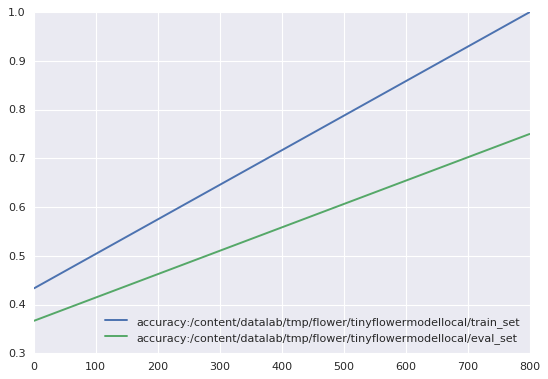

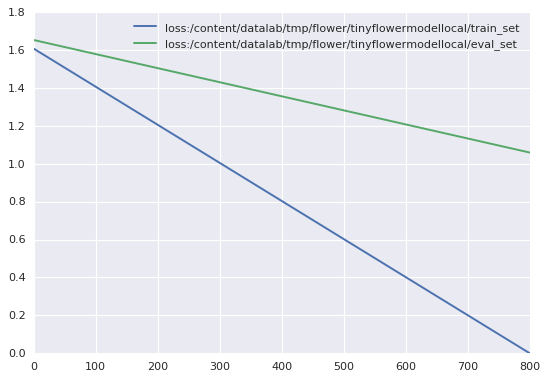

In [55]:
summary.plot('accuracy')
summary.plot('loss')

## Predict
Let's start with a quick check by taking a couple of images and using the model to predict the type of flower locally.

Predicting...


daisy(0.99814)

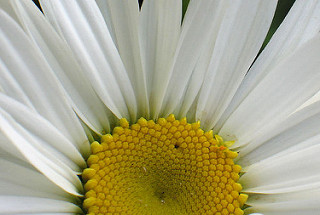

tulips(0.99947)

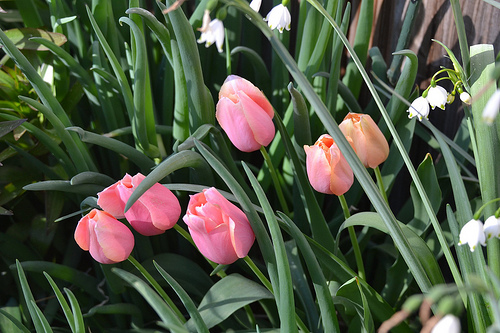

,image_url,label,score
0,gs://cloud-ml-data/img/flower_photos/daisy/152...,daisy,0.998137
1,gs://cloud-ml-data/img/flower_photos/tulips/68...,tulips,0.999473


In [56]:
images = [
  'gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg',
  'gs://cloud-ml-data/img/flower_photos/tulips/6876631336_54bf150990.jpg'
]
# set show_image to False to not display pictures.
model.predict(model_dir, images, show_image=True)

## Evaluate
We did a quick test of the model using a few samples. But we need to understand how the model does by evaluating it against much larger amount of labeled data. In the initial preprocessing step, we did set aside enough images for that purpose. Next, we will use normal batch prediction and compare the results with the previously labeled targets.

The following batch prediction and loading of results takes ~3 minutes.

In [57]:
import google.datalab.bigquery as bq
bq.Dataset('flower').create()

Dataset bradley-playground:flower

In [58]:
eval_set = CsvDataSet(local_eval_file, schema='image_url:STRING,label:STRING')
batch_predict_job = model.batch_predict(eval_set, model_dir, output_bq_table='flower.eval_results_local')
batch_predict_job.wait()

Job batch-predict-image-classification-170302-221030 completed

Now that we have the results and expected results loaded in a BigQuery table, let's start analyzing the errors and plot the confusion matrix.

In [59]:
%%sql
SELECT * FROM flower.eval_results_local where target != predicted

image_url,target,predicted,target_prob,predicted_prob
/content/datalab/tmp/flower/images/24459750_eb49f6e4cb_m.jpg,sunflowers,roses,0.00275354087353,0.926409840584
/content/datalab/tmp/flower/images/850416050_31b3ff7086.jpg,roses,tulips,0.377575695515,0.572745025158
/content/datalab/tmp/flower/images/3145692843_d46ba4703c.jpg,roses,sunflowers,2.26716911129e-05,0.999803245068
/content/datalab/tmp/flower/images/4556178143_e0d32c0a86_n.jpg,dandelion,sunflowers,0.124214045703,0.873298466206
/content/datalab/tmp/flower/images/6166888942_7058198713_m.jpg,sunflowers,tulips,0.0267491322011,0.901426553726
/content/datalab/tmp/flower/images/14674389605_df3c0bcfa1_m.jpg,tulips,roses,0.023204786703,0.973887503147
/content/datalab/tmp/flower/images/14088053307_1a13a0bf91_n.jpg,daisy,dandelion,0.04393896088,0.491752892733
/content/datalab/tmp/flower/images/14651385476_7ccb20e594_m.jpg,tulips,roses,0.459434360266,0.484324902296
/content/datalab/tmp/flower/images/17040847367_b54d05bf52.jpg,roses,tulips,0.0285660810769,0.970412552357
/content/datalab/tmp/flower/images/3705716290_cb7d803130_n.jpg,roses,tulips,0.285338491201,0.71074783802


Confusion matrix is a common way of comparing the confusion of the model - aggregate data about where the actual result did not match the expected result.

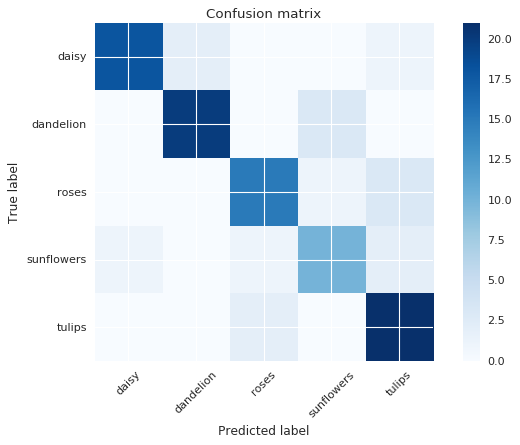

In [60]:
ConfusionMatrix.from_bigquery('flower.eval_results_local').plot()

More advanced analysis can be done using the feature slice view. For the feature slice view, let's define SQL queries that compute accuracy and log loss and then use the metrics.

In [61]:
%%sql --module accuracy
SELECT
  target,
  SUM(CASE WHEN target == predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target == predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy,
FROM
  flower.eval_results_local
GROUP BY
  target

In [62]:
%%bigquery execute -q accuracy

target,correct,total,accuracy
roses,15,19,0.789473684211
sunflowers,10,14,0.714285714286
daisy,18,21,0.857142857143
tulips,21,23,0.913043478261
dandelion,20,23,0.869565217391


In [63]:
%%sql --module logloss

SELECT feature, AVG(-logloss) as logloss, count(*) as count FROM
(
SELECT feature, CASE WHEN correct == 1 THEN LOG(prob) ELSE LOG(1-prob) END as logloss,
FROM
(
SELECT
target as feature, 
CASE WHEN target == predicted THEN 1 ELSE 0 END as correct,
target_prob as prob
FROM flower.eval_results_local))
GROUP BY feature

In [64]:
FeatureSliceView().plot(logloss)

## Clean up

In [65]:
import shutil

bq.Dataset('flower').delete(delete_contents=True)
shutil.rmtree(worker_dir)

## Recap
In this notebook, we covered local preprocessing, training, prediction and evaluation. We started from data in GCS in csv form plus images; used transfer learning for very fast training and then used BigQuery for model performance analysis. In the next notebook, we will use CloudML APIs that scale a lot better for larger scale. The syntax and analyses will remain the same.